### Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [217]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import auxiliar functions
%autoreload 2
from Auxiliary import *

### Input variables

In [344]:
''' crystal variables  '''
crystal_type='220'
ang_as = np.deg2rad(5)           # asymmetric angle

if crystal_type == '111':
    ''' Silicon 111 crystal '''
    d_sp = 3.13557135638            # reflecting plane d-spacing [A]
    psi0r = -5.11321939903e-05      # real part of 0th Fourier component of crystal polarizability
    psi0i = 3.58887560736e-06       # imaginary part of ""
    psi_hr = -2.71341902391e-05     # real part of Hth Fourier component
    psi_hi = 2.50565837652e-06      # imaginary part of ""
    psi_hbr = -2.71341902391e-05    # real part of -Hth Fourier coumponent
    psi_hbi = 2.50565837652e-06     # imaginary part of ""
    
if crystal_type == '220':
    ''' Silicon 220 crystal '''
    d_sp = 1.9201374688016222        # reflecting plane d-spacing [A]
    psi0r = -9.7640050694412e-06     # real part of 0th Fourier component of crystal polarizability
    psi0i = 1.4938680132506875e-07   # imaginary part of ""
    psi_hr = -5.932463856370471e-06  # real part of Hth Fourier component
    psi_hi = 1.44406950529943e-07    # imaginary part of ""
    psi_hbr = -5.932463856370471e-06 # real part of -Hth Fourier coumponent
    psi_hbi = 1.44406950529943e-07   # imaginary part of ""
    
tc = 0.01                        # crystal thickness
uc = 1                           # use case: 1 (Bragg reflection); 2 (Bragg transmission)
ang_dif_pl = 0                   # diffraction plane angle: 0 (vertical); pi/2 (horizontal)
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

# lens parameters (PMMA)
n = 1 - 5.89e-6         # material refractive index
#d_abs = 788e-6          # material absorption depth
d_abs = 1
f_lens = 1              # lens focal distance

# aperture parameters
Apt_width = 1000e-6      # aperture width (1D)
acentx = 0              # center of aperture [m]
acenty = 0

''' incident beam variables '''
ekev = 10.0                 # photon energy [kev]
pulse_duration = 50e-15    # pulse duration (rms) [t]
z1 = 200.0                  # distance to first OE [m]
sigX = 50e-6/2.36           # w0 (rms) [m]
npoints = 5000              # wavefront sampling dimension
if_load_input = 0           # load (1) or generate (0) incident wavefront

# default values
qnC = 0.1                   # charge [nC]
pulseEnergy = 0.5e-3        # pulse energy [J]
dt = 0.5e-15                # time sampling resolution
if pulse_duration/dt <= 10:
    print('incident beam too short, changing to finer sampling resolution ...')
    dt = 0.1e-15
    if pulse_duration/dt <= 10:
        print(".... okay, the beam is really too short, simulation might break down")
hbar = 6.582119569e-16

# input dimensions
npointsx = 2                # number of points vs horizontal position
npointsy = npoints          # """"""""""""""""""  vertical position

### Calculate sampling parameters

In [345]:
''' calculations '''
wl0 = E2L(ekev*1e3)                 # wavelength
k0 = 2*np.pi/wl0                    # wavenumber
divergence = wl0/np.pi/sigX         # paraxial beam divergence (rms)
range_xy = divergence/2 * z1 * 10    # spatial sampling range (5 sigma)

nvx0, nvy0, nvz0 = Temp_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]
thetaB0 = np.arctan(-nvz0/nvy0)+ang_as

trange = calc_stretching(thetaB0, ang_as, range_xy)    # stretched pulse duration
pulseRange = trange/pulse_duration

if pulseRange < 400:
    pulseRange = 400
    trange = pulse_duration * pulseRange

if trange > 1000e-15:
    trange = 1000e-15
    pulseRange = trange/pulse_duration

if trange < 300e-15:
    trange = 300e-15
    pulseRange = trange/pulse_duration

dev = 1/trange * 2*np.pi * hbar     # photon energy sampling resolution
nz = int(trange/dt)                 # number of photon energy slices
if nz % 2!=0:
    nz += 1
    
''' diffraction limit and focal spot Rayleigh range '''
thetamax = 2*np.arctan(divergence/2*z1*3/f_lens)
dlim = wl0/2/n/np.sin(thetamax)     # diffraction limit
zR = 1/2 * k0 * dlim**2             # focal spot Rayleigh range

print('beam parameters:\n    {}keV, {}fs, {}um w0, {}urad divergence'.format(
    ekev, round(pulse_duration*1e15,2), round(sigX*1e6,2), round(divergence*1e6,2)))
print('sampling parameters:\n    {}fs dt, {}meV deV, {} nz, {} pulseRange'.format(
    round(dt*1e15,2), round(dev*1e3,2), nz, round(pulseRange,2)))
print('other parameters:\n    Bragg angle {}deg, stretched pulse length {}fs'.format(
    round(np.rad2deg(thetaB0),2),round(trange*1e15,2)))
print('diffraction limit {}um, Rayleigh range {}mm, Fresnel distance {}um'.format(
    round(dlim*1e6,2), round(zR*1e3,2), round((3e8*0.1e-15)**2/wl0*1e6,2)))


beam parameters:
    10.0keV, 50.0fs, 21.19um w0, 1.86urad divergence
sampling parameters:
    0.5fs dt, 4.14meV deV, 2000 nz, 20.0 pulseRange
other parameters:
    Bragg angle 18.84deg, stretched pulse length 1000.0fs
diffraction limit 0.06um, Rayleigh range 0.08mm, Fresnel distance 7.25um


In [346]:
''' directories '''
# output data directory
strDataFolderName = 'WPG_output/Hasan_Mono/' 
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

# sub-folder for current sampling parameters
dirname_duration = strDataFolderName+'Si_{}_{}fs_beam/'.format(
    crystal_type,round(pulse_duration*1e15,1))
if not os.path.exists(dirname_duration):
    mkdir_p(dirname_duration)

# sub-sub-folder for incident beam
dirname_input = dirname_duration+'incident_beam/'
if not os.path.exists(dirname_input):
    mkdir_p(dirname_input)

# sub-sub-folder for propagated beam
dirname_prop = dirname_duration+'propagation/'
if not os.path.exists(dirname_prop):
    mkdir_p(dirname_prop)

''' filenames '''
name0 = 'incident'
name1 = 'cc1'
name2 = 'lens0'
name3 = 'apt'
name4 = 'lens1'
name5 = 'cc2'

fname_incident = dirname_input+'incident_compressed.h5'
fname_cc1 = dirname_prop+'wf_{}um_slit_{}_compressed.h5'.format(round(Apt_width*1e6,2),name1)
fname_l0  = dirname_prop+'wf_{}um_slit_{}_compressed.h5'.format(round(Apt_width*1e6,2),name2)
fname_apt = dirname_prop+'wf_{}um_slit_{}_compressed.h5'.format(round(Apt_width*1e6,2),name3)
fname_l1  = dirname_prop+'wf_{}um_slit_{}_compressed.h5'.format(round(Apt_width*1e6,2),name4)
fname_cc2 = dirname_prop+'wf_{}um_slit_{}_compressed.h5'.format(round(Apt_width*1e6,2),name5)


### Plot results

### Quantifying monochromator performance

### 1. spectral intensity
    ratio of output spectral intensity after each OE and the incident spectral intensity.

'\nThe bandwidth should only change after each pair of crystals as shown below.\n    top: bandwidth = intensity_out/intensity_in\n    bottom: bandwidth = bandwidth/bandwidth.max()\nQuestion:\n    Should I normalize the spectrum of each before division?\n    i.e.\n        intensity_out /= intensity_out.max()\n        intensity_in /= intensity_in.max()\n\n'

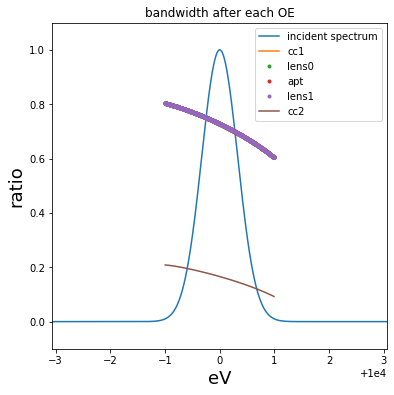

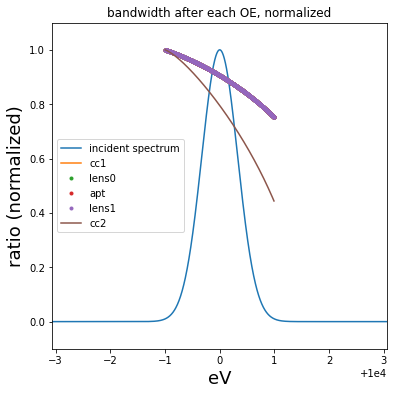

In [347]:
''' spectral intensity '''
# per OE
if_norm = 0
plt.figure(figsize=(6,6))
plot_spectra(aw, evI, intIs, 'C0', label='incident spectrum')
plot_spectral_response(aw, evI, intIs, intCC1s, 'C1', label=name1, if_norm=if_norm)
plot_spectral_response(aw, evI, intIs, intL0s, 'C2.', label=name2, if_norm=if_norm)
plot_spectral_response(aw, evI, intIs, intApts, 'C3.', label=name3, if_norm=if_norm)
plot_spectral_response(aw, evI, intIs, intL1s, 'C4.', label=name4, if_norm=if_norm)
plot_spectral_response(aw, evI, intIs, intCC2s, 'C5', label=name5, if_norm=if_norm)
plt.xlim([eMin, eMax])
plt.title('bandwidth after each OE')
plt.legend()

plt.savefig(dirname_prop+'bandwidth_{}um_slit.png'.format(
    round(Apt_width*1e6,2)), transparent=True)


### 2. resolution limit

    diffraction limit divided by the full width of beam at focal plane
$$lim_{eV} = \frac{d_{lim}}{d_{beam}}range_{eV} $$

diffraction limit 0.055 um
resolution limit 22.76meV
sampling resolution 4.14meV


'\nNote:\n    instead of the total width at focal plane, I should probably calculate \n    the position of the focused "fringes" of the meaningful photon energy min and max,\n    then subtract the two positions to get the real "d_beam" of the device.\n    However, the eV range in the spatial spectrum plot is very limited.\n        -> need to check the log-scale and see if enough intensity is registered.\n'

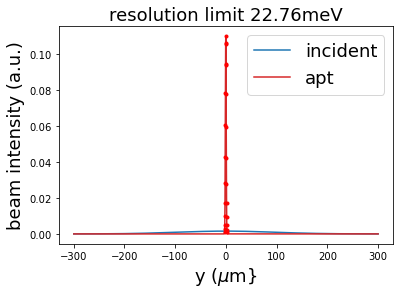

In [348]:
''' resolution limit '''
if_log = 0
if_norm = 1
plt.figure()
plot_lineout_from_file(fname_incident,'C0',name0,fov_y,if_log,if_norm)
plot_lineout_from_file(fname_apt,'C3',name3,fov_y,if_log,if_norm)

# beam width at focal plane
axis, lineout, ori = get_lineout_from_file(fname_apt)
irange = np.argwhere(lineout>=lineout.max()*0.01)
width = np.abs(axis[irange.min()]-axis[irange.max()])
plt.plot(axis[irange],(lineout/lineout.sum())[irange],'r.',label='{} um'.format(round(width,2)))

# total energy range at slit
range_ev = np.abs(evApt[aw.min()]-evApt[aw.max()])
lim_ev = dlim*1e6/width * range_ev
plt.title('resolution limit {}meV'.format(
    round(lim_ev*1e3,2)), fontsize=18)

plt.savefig(dirname_prop+'resolution_limit_{}um_slit.png'.format(
    round(Apt_width*1e6,2)), transparent=True)

print('diffraction limit {} um'.format(round(dlim*1e6,3)))
print('resolution limit {}meV'.format(round(lim_ev*1e3,2)))
print('sampling resolution {}meV'.format(round(dev*1e3,2)))

'''
Note:
    instead of the total width at focal plane, I should probably calculate 
    the position of the focused "fringes" of the meaningful photon energy min and max,
    then subtract the two positions to get the real "d_beam" of the device.
    However, the eV range in the spatial spectrum plot is very limited.
        -> need to check the log-scale and see if enough intensity is registered.
'''

### 3. throughput

    total transmitted power at each OE

In [351]:
''' throughput '''
throughput = np.asarray([
    get_throughput_from_file(fname_incident, fname_cc1),
    get_throughput_from_file(fname_incident, fname_l0),
    get_throughput_from_file(fname_incident, fname_apt),
    get_throughput_from_file(fname_incident, fname_l1),
    get_throughput_from_file(fname_incident, fname_cc2)
    ])

np.savetxt(dirname_prop+'throughput_{}um_slit.txt'.format(
    round(Apt_width*1e6,2)), throughput, delimiter=',')

print('through put at \n{}: {}%, \n{}: {}%, \n{}: {}%, \n{}: {}%, \n{}: {}%'.format(
    name1, round(100*throughput[0],2),
    name2, round(100*throughput[1],2),
    name3, round(100*throughput[2],2),
    name4, round(100*throughput[3],2),
    name5, round(100*throughput[4],2)
    ))

'''
Note:
    the total power at each OE is calcualted as the square of lineout.sum(),
    and the throughput is power_OE / power_incident

'''

through put at 
cc1: 90.27%, 
lens0: 90.22%, 
apt: 90.22%, 
lens1: 90.17%, 
cc2: 81.39%


'\nNote:\n    the total power at each OE is calcualted as the square of lineout.sum(),\n    and the throughput is power_OE / power_incident\n\n'